# Simulating lightcurves for SNe Ia

In [5]:
import os
home_dir = os.environ.get('HOME')

# Please enter the filename of the ztf_sim output file you would like to use. The example first determines
# your home directory and then uses a relative path (useful if working on several machines with different usernames)
survey_file = os.path.join(home_dir, 'data/ZTF/one_year_sim_incomplete.db')

# Please enter the path to where you have placed the Schlegel, Finkbeiner & Davis (1998) dust map files
# You can also set the environment variable SFD_DIR to this path (in that case the variable below should be None)
sfd98_dir = os.path.join(home_dir, 'data/sfd98')

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import simsurvey

In [7]:
# Load the CCD corners from file
ccd_corners = np.genfromtxt('data/ZTF_corners.txt')
ccds = [ccd_corners[4*k+16:4*k+20] for k in range(16)]

In [ ]:
bands = { 
  'ztfr' : 'data/ztfr_eff.txt',
  'ztfg' : 'data/ztfg_eff.txt',
  }

for bandname in bands.keys() :
    fname = bands[bandname]
    b = np.loadtxt(fname)
    band = sncosmo.Bandpass(b[:,0], b[:,1], name=bandname)
    sncosmo.registry.register(band)

In [8]:
# Load simulated survey from file (download from ftp://ftp.astro.caltech.edu/users/ebellm/one_year_sim_incomplete.db)
plan = simsurvey.SurveyPlan(load_opsim=survey_file, band_dict={'g': 'ztfg', 'r': 'ztfr'}, ccds=ccds)

mjd_range = (plan.cadence['time'].min(), plan.cadence['time'].max())

In [9]:
tr = simsurvey.get_sn_generator([0.,0.2], ratekind="basic", 
                            dec_range=[-30,90],
                            mjd_range=[mjd_range[0] - 60, mjd_range[-1] + 24],
                            sfd98_dir=sfd98_dir)

In [11]:
instprop = {"ztfg":{"gain":1.,"zp":30,"zpsys":'ab'},
            "ztfr":{"gain":1.,"zp":30,"zpsys":'ab'}}

survey = simsurvey.SimulSurvey(generator=tr, plan=plan, instprop=instprop)

lcs = survey.get_lightcurves(
    progress_bar=True, notebook=True # If you get an error because of the progress_bar, delete this line.
)

In [13]:
lcs[0]

time,band,flux,fluxerr,zp,zpsys,field,ccd
float64,str4,float64,float64,int64,str2,int64,int64
57455.3855976,desr,-1658.2581089,668.28830748,30,ab,376,5
57455.3860606,desr,787.507751254,668.288311012,30,ab,376,5
57455.4274791,desr,1342.54654474,763.476462269,30,ab,376,5
57455.4279421,desr,28.7796779008,763.476465518,30,ab,376,5
57462.2256251,desg,-551.234311784,797.59980565,30,ab,376,5
57462.2260881,desg,245.822049185,797.599878,30,ab,376,5
57462.2715879,desg,473.345998858,637.260013391,30,ab,376,5
57462.2720509,desg,1215.84092118,637.260104497,30,ab,376,5
57467.2523212,desr,3190.52548879,1875.92762162,30,ab,376,5


## Analysing the output

The output of `get_lightcurves()` is a `LightcurveCollection` object. Below are some examples how to assess survey statistics based on this.

The first skyplot shows all SNe that were active when a field was observed (but they may have been too faint to be detected). The second skyplot shows the SNe that had at least one $5\sigma$ detection. 

you do not have shapely installed. Some function will not be accessible.
--> pip install Shapely


/home/ufein/.local/lib/python2.7/site-packages/astrobject-0.3.6-py2.7.egg/astrobject/astrometry.py:16: UserWarning: ImportError - astLib can not be imported ; PTF-like images won't load.
/home/ufein/.local/lib/python2.7/site-packages/simsurvey-0.2.0-py2.7.egg/simsurvey/simultarget.py:310: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python2.7/dist-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


SNe pointed to: 24210 out of 33839


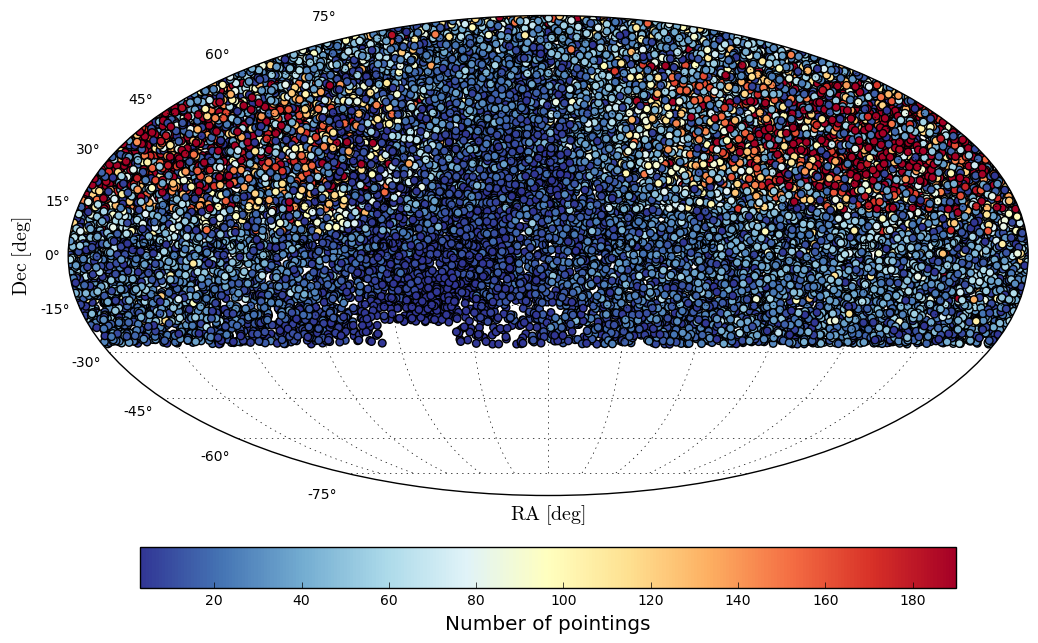

In [14]:
idx = lcs.meta['idx_orig']
n_obs = np.zeros(survey.generator.ntransient)
n_obs[idx] = np.array([len(a) for a in lcs])

survey.generator.show_skycoverage(cscale=n_obs, cblabel="Number of pointings", mask=idx)
print 'SNe pointed to: %i out of %i'%(np.sum(n_obs > 0), survey.generator.ntransient)

SNe detected: 15292 out of 33839


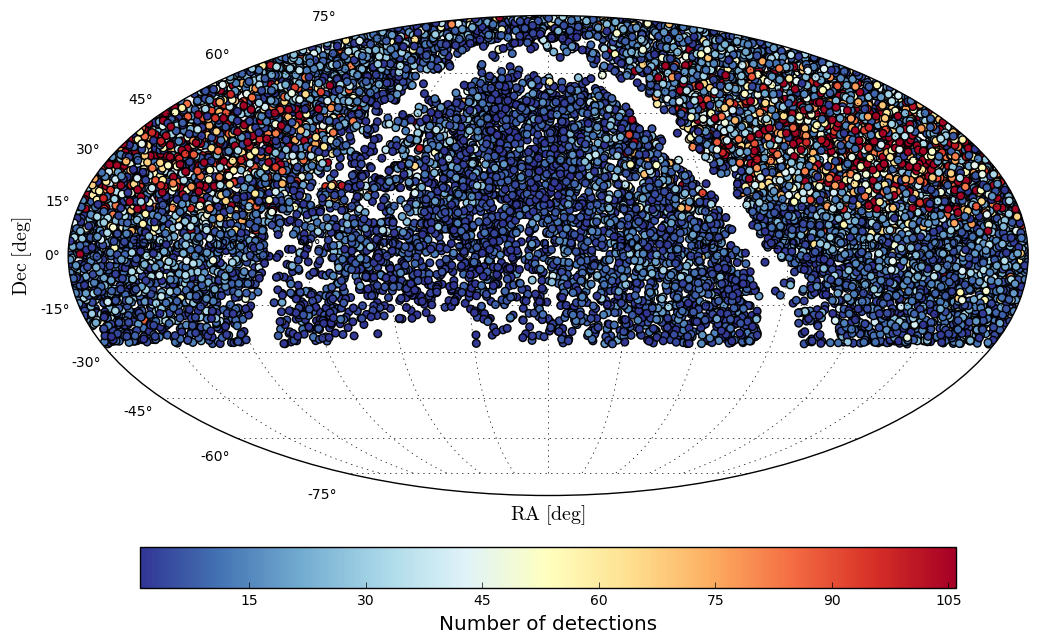

In [15]:
t_exp = -20

lcs_det = [lc[lc['flux']/lc['fluxerr'] > 5] for lc in lcs]
lcs_det = [lc[lc['time'] > t_exp*(1+lc.meta['z']) + lc.meta['t0']] for lc in lcs_det]

idx_det = lcs.meta['idx_orig'][np.array([len(lc) > 0 for lc in lcs_det])]
n_det = np.zeros(survey.generator.ntransient)
lcs_det = [lc for lc in lcs_det if len(lc) > 0]
n_det[idx_det] = np.array([len(a) for a in lcs_det])

survey.generator.show_skycoverage(cscale=n_det, cblabel="Number of detections", mask=idx_det)
print 'SNe detected: %i out of %i'%(np.sum(n_det > 0), survey.generator.ntransient)

In [16]:
z = np.array([lc.meta['z'] for lc in lcs_det])
p_i = np.array([lc['time'].min() - lc.meta['t0'] for lc in lcs_det])
p_e = np.array([lc['time'].max() - lc.meta['t0'] for lc in lcs_det])

The two last figures show how early the SNe are detected and at what redshift.

SNe found before peak: 11029


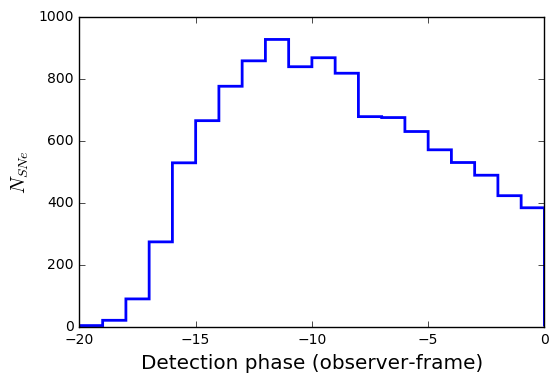

In [17]:
plt.hist(p_i, lw=2, histtype='step', range=(-20,0), bins=20)
print 'SNe found before peak:', np.sum(p_i < 0)
plt.xlabel('Detection phase (observer-frame)', fontsize='x-large')
plt.ylabel(r'$N_{SNe}$', fontsize='x-large')

SNe found 14 observer-frame days before peak: 1577
Local SNe (z < 0.1) found 14 observer-frame days before peak: 554


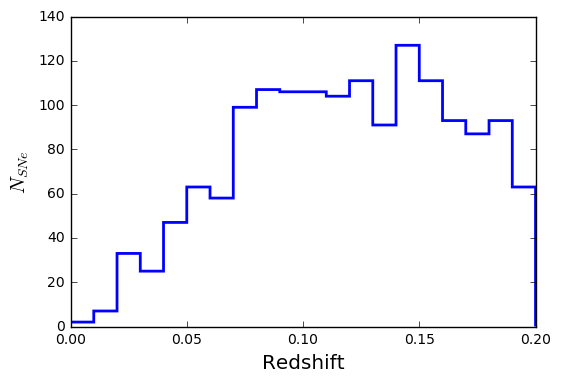

In [18]:
p_lim = -14
n = np.array([len(lc) for lc in lcs_det])
snr_max = np.array([max(lc['flux']/lc['fluxerr']) for lc in lcs_det])
plt.hist(z[(p_i < p_lim) & (snr_max >= 10)], lw=2, histtype='step', range=(0,0.2),bins=20)
print 'SNe found 14 observer-frame days before peak:', np.sum(p_i < p_lim) 
print 'Local SNe (z < 0.1) found 14 observer-frame days before peak:', np.sum((p_i < p_lim) & (z < 0.1))
plt.xlabel('Redshift', fontsize='x-large')
plt.ylabel(r'$N_{SNe}$', fontsize='x-large')
_ = plt.xlim((0, 0.2))